# LSTM - vanilla

In [1]:
best_model = "best_model1.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [14]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


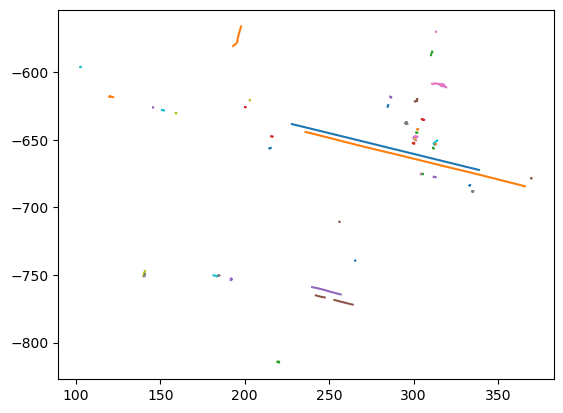

In [15]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [16]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [18]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [19]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x[..., :5]
        x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # Process through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Extract final hidden state
        features = lstm_out[:, -1, :]
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [20]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [21]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=5, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 9.07
        # lr = 0.01 => 9.18
        lr=0.005,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [22]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_61366/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_61366/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:16<27:28, 16.65s/epoch]

Epoch 000 | LR 0.004750 | Train MSE 0.7873 | Val MSE 0.4501 | Val MAE 2.9373 | Val MSE 22.0546
Sample pred first 3 steps: [[ 0.00608007 -0.00202134]
 [ 0.01503187  0.00939552]
 [ 0.02598602 -0.02557519]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 0.450093


Epoch:   2%|▏         | 2/100 [00:24<18:59, 11.63s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.4270 | Val MSE 0.4061 | Val MAE 2.4512 | Val MSE 19.8988
Validation improved: 0.450093 -> 0.406097


Epoch:   3%|▎         | 3/100 [00:32<15:52,  9.82s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.4126 | Val MSE 0.3965 | Val MAE 2.4048 | Val MSE 19.4293
Validation improved: 0.406097 -> 0.396516


Epoch:   4%|▍         | 4/100 [00:40<14:42,  9.20s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.4067 | Val MSE 0.4063 | Val MAE 2.5434 | Val MSE 19.9080


Epoch:   5%|▌         | 5/100 [00:48<13:45,  8.69s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.4004 | Val MSE 0.4310 | Val MAE 2.7186 | Val MSE 21.1208


Epoch:   5%|▌         | 5/100 [00:55<13:45,  8.69s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.3988 | Val MSE 0.4309 | Val MAE 2.6262 | Val MSE 21.1134
Sample pred first 3 steps: [[0.00059857 0.00361983]
 [0.01134086 0.01151697]
 [0.00533229 0.00738148]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:   7%|▋         | 7/100 [01:04<12:39,  8.17s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.3854 | Val MSE 0.3419 | Val MAE 2.3234 | Val MSE 16.7517
Validation improved: 0.396516 -> 0.341872


Epoch:   8%|▊         | 8/100 [01:12<12:26,  8.11s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.3371 | Val MSE 0.3303 | Val MAE 2.3750 | Val MSE 16.1844
Validation improved: 0.341872 -> 0.330295


Epoch:   9%|▉         | 9/100 [01:19<12:00,  7.92s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.3153 | Val MSE 0.2881 | Val MAE 2.0290 | Val MSE 14.1186
Validation improved: 0.330295 -> 0.288136


Epoch:  10%|█         | 10/100 [01:27<11:55,  7.95s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.2943 | Val MSE 0.2708 | Val MAE 2.0475 | Val MSE 13.2685
Validation improved: 0.288136 -> 0.270786


Epoch:  11%|█         | 11/100 [01:35<11:44,  7.91s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.2700 | Val MSE 0.2396 | Val MAE 1.8707 | Val MSE 11.7420
Sample pred first 3 steps: [[-0.0034011  -0.00200947]
 [-0.00495203 -0.0008721 ]
 [-0.00360199 -0.0029145 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.270786 -> 0.239633


Epoch:  12%|█▏        | 12/100 [01:43<11:45,  8.02s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.2535 | Val MSE 0.2211 | Val MAE 1.6627 | Val MSE 10.8353
Validation improved: 0.239633 -> 0.221129


Epoch:  13%|█▎        | 13/100 [01:51<11:28,  7.91s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.2516 | Val MSE 0.2126 | Val MAE 1.6646 | Val MSE 10.4175
Validation improved: 0.221129 -> 0.212602


Epoch:  14%|█▍        | 14/100 [01:59<11:23,  7.95s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.2387 | Val MSE 0.2283 | Val MAE 1.8128 | Val MSE 11.1869


Epoch:  15%|█▌        | 15/100 [02:07<11:09,  7.87s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.2325 | Val MSE 0.2077 | Val MAE 1.5304 | Val MSE 10.1770
Validation improved: 0.212602 -> 0.207694


Epoch:  16%|█▌        | 16/100 [02:14<10:59,  7.86s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.2327 | Val MSE 0.2079 | Val MAE 1.6394 | Val MSE 10.1850
Sample pred first 3 steps: [[-0.00152288  0.00142896]
 [-0.00433227 -0.00048035]
 [-0.01135247  0.0015898 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  17%|█▋        | 17/100 [02:22<10:41,  7.73s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.2254 | Val MSE 0.1975 | Val MAE 1.5600 | Val MSE 9.6755
Validation improved: 0.207694 -> 0.197459


Epoch:  18%|█▊        | 18/100 [02:29<10:19,  7.56s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.2193 | Val MSE 0.2062 | Val MAE 1.6209 | Val MSE 10.1018


Epoch:  19%|█▉        | 19/100 [02:37<10:13,  7.58s/epoch]

Epoch 018 | LR 0.001887 | Train MSE 0.2215 | Val MSE 0.1929 | Val MAE 1.5159 | Val MSE 9.4537
Validation improved: 0.197459 -> 0.192932


Epoch:  20%|██        | 20/100 [02:45<10:23,  7.80s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.2142 | Val MSE 0.1983 | Val MAE 1.6012 | Val MSE 9.7176


Epoch:  21%|██        | 21/100 [02:52<10:11,  7.75s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.2102 | Val MSE 0.2109 | Val MAE 1.6949 | Val MSE 10.3332
Sample pred first 3 steps: [[-0.00521695  0.00191025]
 [ 0.00410661  0.01153122]
 [ 0.0089887   0.015685  ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [03:00<10:03,  7.74s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.2142 | Val MSE 0.1891 | Val MAE 1.4928 | Val MSE 9.2682
Validation improved: 0.192932 -> 0.189147


Epoch:  23%|██▎       | 23/100 [03:07<09:42,  7.57s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.2088 | Val MSE 0.1892 | Val MAE 1.5314 | Val MSE 9.2694


Epoch:  24%|██▍       | 24/100 [03:16<09:48,  7.74s/epoch]

Epoch 023 | LR 0.001460 | Train MSE 0.2077 | Val MSE 0.1909 | Val MAE 1.5319 | Val MSE 9.3549


Epoch:  25%|██▌       | 25/100 [03:23<09:39,  7.72s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.2066 | Val MSE 0.1875 | Val MAE 1.5343 | Val MSE 9.1893
Validation improved: 0.189147 -> 0.187537


Epoch:  26%|██▌       | 26/100 [03:32<09:54,  8.04s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.2060 | Val MSE 0.1815 | Val MAE 1.4578 | Val MSE 8.8921
Sample pred first 3 steps: [[ 0.00238839 -0.00029224]
 [ 0.00237755  0.00212105]
 [ 0.00306387  0.00112574]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.187537 -> 0.181472


Epoch:  27%|██▋       | 27/100 [03:39<09:30,  7.81s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.2023 | Val MSE 0.1869 | Val MAE 1.4708 | Val MSE 9.1561


Epoch:  28%|██▊       | 28/100 [03:47<09:13,  7.68s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.2016 | Val MSE 0.1855 | Val MAE 1.4576 | Val MSE 9.0871


Epoch:  29%|██▉       | 29/100 [03:55<09:14,  7.82s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.2005 | Val MSE 0.1836 | Val MAE 1.4509 | Val MSE 8.9966


Epoch:  30%|███       | 30/100 [04:03<09:08,  7.83s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.2019 | Val MSE 0.1848 | Val MAE 1.4575 | Val MSE 9.0550


Epoch:  31%|███       | 31/100 [04:10<08:56,  7.77s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.1965 | Val MSE 0.1836 | Val MAE 1.4327 | Val MSE 8.9985
Sample pred first 3 steps: [[ 0.00057296  0.00050143]
 [-0.00178208  0.00525156]
 [ 0.00121284  0.00421727]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  32%|███▏      | 32/100 [04:19<08:59,  7.93s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.1966 | Val MSE 0.1788 | Val MAE 1.4336 | Val MSE 8.7594
Validation improved: 0.181472 -> 0.178763


Epoch:  33%|███▎      | 33/100 [04:27<09:11,  8.24s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.1965 | Val MSE 0.1783 | Val MAE 1.4227 | Val MSE 8.7366
Validation improved: 0.178763 -> 0.178298


Epoch:  34%|███▍      | 34/100 [04:36<09:17,  8.45s/epoch]

Epoch 033 | LR 0.000874 | Train MSE 0.1957 | Val MSE 0.1833 | Val MAE 1.4715 | Val MSE 8.9819


Epoch:  35%|███▌      | 35/100 [04:45<09:17,  8.58s/epoch]

Epoch 034 | LR 0.000830 | Train MSE 0.1955 | Val MSE 0.1812 | Val MAE 1.4448 | Val MSE 8.8812


Epoch:  36%|███▌      | 36/100 [04:55<09:23,  8.80s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.1931 | Val MSE 0.1827 | Val MAE 1.4963 | Val MSE 8.9534
Sample pred first 3 steps: [[-0.00068155 -0.00093721]
 [-0.0018591  -0.00539473]
 [-0.00631961 -0.00714902]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [05:03<09:15,  8.81s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.1930 | Val MSE 0.1770 | Val MAE 1.3891 | Val MSE 8.6736
Validation improved: 0.178298 -> 0.177013


Epoch:  38%|███▊      | 38/100 [05:13<09:16,  8.97s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.1915 | Val MSE 0.1830 | Val MAE 1.4529 | Val MSE 8.9665


Epoch:  39%|███▉      | 39/100 [05:23<09:29,  9.34s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.1911 | Val MSE 0.1806 | Val MAE 1.3885 | Val MSE 8.8509


Epoch:  40%|████      | 40/100 [05:31<09:02,  9.04s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.1887 | Val MSE 0.1806 | Val MAE 1.4083 | Val MSE 8.8507


Epoch:  41%|████      | 41/100 [05:40<08:37,  8.78s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.1893 | Val MSE 0.1750 | Val MAE 1.3858 | Val MSE 8.5747
Sample pred first 3 steps: [[ 8.8309508e-04 -1.5767633e-03]
 [ 1.2962695e-03  3.4632627e-05]
 [ 1.0081399e-03  1.1136974e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.177013 -> 0.174995


Epoch:  42%|████▏     | 42/100 [05:49<08:34,  8.88s/epoch]

Epoch 041 | LR 0.000580 | Train MSE 0.1892 | Val MSE 0.1779 | Val MAE 1.3954 | Val MSE 8.7156


Epoch:  43%|████▎     | 43/100 [05:58<08:30,  8.95s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.1877 | Val MSE 0.1798 | Val MAE 1.4576 | Val MSE 8.8122


Epoch:  44%|████▍     | 44/100 [06:07<08:19,  8.93s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.1878 | Val MSE 0.1782 | Val MAE 1.3733 | Val MSE 8.7304


Epoch:  45%|████▌     | 45/100 [06:15<07:58,  8.69s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.1882 | Val MSE 0.1764 | Val MAE 1.3894 | Val MSE 8.6435


Epoch:  46%|████▌     | 46/100 [06:24<07:58,  8.86s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.1870 | Val MSE 0.1782 | Val MAE 1.3828 | Val MSE 8.7306
Sample pred first 3 steps: [[ 0.00068293  0.00028813]
 [ 0.00010315  0.0018648 ]
 [-0.00045111  0.002125  ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  47%|████▋     | 47/100 [06:33<07:54,  8.96s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.1854 | Val MSE 0.1768 | Val MAE 1.3897 | Val MSE 8.6620


Epoch:  48%|████▊     | 48/100 [06:43<07:51,  9.07s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.1862 | Val MSE 0.1780 | Val MAE 1.3813 | Val MSE 8.7204


Epoch:  49%|████▉     | 49/100 [06:51<07:40,  9.02s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.2252 | Val MSE 0.1761 | Val MAE 1.3920 | Val MSE 8.6295


Epoch:  49%|████▉     | 49/100 [07:00<07:17,  8.58s/epoch]


KeyboardInterrupt: 

In [12]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_17014/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_17014/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:06<11:15,  6.82s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 1.2067 | Val MSE 0.4351 | Val MAE 2.6612 | Val MSE 21.3204
Sample pred first 3 steps: [[ 0.02239771 -0.00033825]
 [-0.00059332  0.00223282]
 [ 0.02362346 -0.00441078]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 0.435110


Epoch:   2%|▏         | 2/100 [00:12<10:00,  6.12s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.4282 | Val MSE 0.4594 | Val MAE 2.7040 | Val MSE 22.5115


Epoch:   3%|▎         | 3/100 [00:18<09:31,  5.89s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.4196 | Val MSE 0.3764 | Val MAE 2.2427 | Val MSE 18.4451
Validation improved: 0.435110 -> 0.376431


Epoch:   4%|▍         | 4/100 [00:23<09:21,  5.85s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.3872 | Val MSE 0.3282 | Val MAE 2.1683 | Val MSE 16.0820
Validation improved: 0.376431 -> 0.328205


Epoch:   5%|▌         | 5/100 [00:29<09:12,  5.81s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.3653 | Val MSE 0.3163 | Val MAE 2.1280 | Val MSE 15.4973
Validation improved: 0.328205 -> 0.316271


Epoch:   6%|▌         | 6/100 [00:35<09:06,  5.81s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.3410 | Val MSE 0.3140 | Val MAE 2.2383 | Val MSE 15.3859
Sample pred first 3 steps: [[ 0.00699447 -0.00435274]
 [ 0.01076489 -0.00629875]
 [ 0.01160193 -0.01160435]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.316271 -> 0.313997


Epoch:   7%|▋         | 7/100 [00:41<09:11,  5.93s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.3164 | Val MSE 0.2680 | Val MAE 1.8740 | Val MSE 13.1342
Validation improved: 0.313997 -> 0.268045


Epoch:   8%|▊         | 8/100 [00:47<09:06,  5.94s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.3065 | Val MSE 0.2904 | Val MAE 2.1976 | Val MSE 14.2273


Epoch:   9%|▉         | 9/100 [00:53<09:03,  5.97s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.2871 | Val MSE 0.2558 | Val MAE 1.7557 | Val MSE 12.5361
Validation improved: 0.268045 -> 0.255840


Epoch:  10%|█         | 10/100 [00:59<08:58,  5.99s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.2849 | Val MSE 0.2610 | Val MAE 1.9168 | Val MSE 12.7867


Epoch:  11%|█         | 11/100 [01:05<08:50,  5.96s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.2676 | Val MSE 0.2507 | Val MAE 1.9064 | Val MSE 12.2845
Sample pred first 3 steps: [[-0.00035519  0.00232838]
 [-0.00358957  0.00394458]
 [-0.01171053  0.00338034]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.255840 -> 0.250704


Epoch:  12%|█▏        | 12/100 [01:11<08:37,  5.88s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.2532 | Val MSE 0.2315 | Val MAE 1.8088 | Val MSE 11.3451
Validation improved: 0.250704 -> 0.231534


Epoch:  13%|█▎        | 13/100 [01:17<08:32,  5.89s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.2470 | Val MSE 0.2204 | Val MAE 1.7580 | Val MSE 10.8010
Validation improved: 0.231534 -> 0.220428


Epoch:  14%|█▍        | 14/100 [01:22<08:21,  5.83s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.2352 | Val MSE 0.2072 | Val MAE 1.6694 | Val MSE 10.1520
Validation improved: 0.220428 -> 0.207183


Epoch:  15%|█▌        | 15/100 [01:28<08:11,  5.78s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.2281 | Val MSE 0.2148 | Val MAE 1.6215 | Val MSE 10.5233


Epoch:  16%|█▌        | 16/100 [01:34<08:03,  5.75s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.2267 | Val MSE 0.2297 | Val MAE 1.7641 | Val MSE 11.2543
Sample pred first 3 steps: [[ 0.00176841  0.00171987]
 [-0.00761777 -0.00167877]
 [-0.00933823  0.00019858]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  17%|█▋        | 17/100 [01:40<08:13,  5.94s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.2252 | Val MSE 0.1951 | Val MAE 1.5331 | Val MSE 9.5615
Validation improved: 0.207183 -> 0.195133


Epoch:  18%|█▊        | 18/100 [01:46<08:09,  5.97s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.2221 | Val MSE 0.2191 | Val MAE 1.7243 | Val MSE 10.7358


Epoch:  19%|█▉        | 19/100 [01:52<08:05,  6.00s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.2290 | Val MSE 0.1988 | Val MAE 1.5619 | Val MSE 9.7426


Epoch:  20%|██        | 20/100 [01:58<07:59,  5.99s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.2136 | Val MSE 0.1952 | Val MAE 1.5236 | Val MSE 9.5647


Epoch:  21%|██        | 21/100 [02:04<07:52,  5.98s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.2138 | Val MSE 0.2017 | Val MAE 1.6217 | Val MSE 9.8833
Sample pred first 3 steps: [[ 0.00111154  0.00182403]
 [-0.00114002  0.00477819]
 [-0.00115115  0.00473868]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [02:10<07:45,  5.97s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.2105 | Val MSE 0.1900 | Val MAE 1.5083 | Val MSE 9.3112
Validation improved: 0.195133 -> 0.190025


Epoch:  23%|██▎       | 23/100 [02:16<07:40,  5.98s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.2070 | Val MSE 0.1823 | Val MAE 1.4618 | Val MSE 8.9342
Validation improved: 0.190025 -> 0.182332


Epoch:  24%|██▍       | 24/100 [02:22<07:36,  6.00s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.2056 | Val MSE 0.1882 | Val MAE 1.5008 | Val MSE 9.2221


Epoch:  25%|██▌       | 25/100 [02:28<07:25,  5.93s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.2075 | Val MSE 0.1941 | Val MAE 1.5263 | Val MSE 9.5102


Epoch:  26%|██▌       | 26/100 [02:34<07:13,  5.86s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.2038 | Val MSE 0.1857 | Val MAE 1.4874 | Val MSE 9.1004
Sample pred first 3 steps: [[-0.00279346 -0.0064277 ]
 [-0.00151791 -0.00225554]
 [-0.00598331 -0.00201665]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  27%|██▋       | 27/100 [02:40<07:17,  5.99s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.2021 | Val MSE 0.1815 | Val MAE 1.4040 | Val MSE 8.8948
Validation improved: 0.182332 -> 0.181527


Epoch:  28%|██▊       | 28/100 [02:46<07:10,  5.98s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.2002 | Val MSE 0.1927 | Val MAE 1.4830 | Val MSE 9.4426


Epoch:  29%|██▉       | 29/100 [02:52<07:00,  5.92s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.1998 | Val MSE 0.2002 | Val MAE 1.5450 | Val MSE 9.8076


Epoch:  30%|███       | 30/100 [02:57<06:54,  5.92s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.1959 | Val MSE 0.1929 | Val MAE 1.4963 | Val MSE 9.4536


Epoch:  31%|███       | 31/100 [03:03<06:48,  5.92s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.1955 | Val MSE 0.1803 | Val MAE 1.4271 | Val MSE 8.8371
Sample pred first 3 steps: [[-0.0071314   0.00223141]
 [-0.00891367 -0.0004987 ]
 [-0.012273    0.00188755]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.181527 -> 0.180349


Epoch:  32%|███▏      | 32/100 [03:09<06:43,  5.94s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.1937 | Val MSE 0.1864 | Val MAE 1.4840 | Val MSE 9.1326


Epoch:  33%|███▎      | 33/100 [03:15<06:34,  5.89s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.1923 | Val MSE 0.1883 | Val MAE 1.4804 | Val MSE 9.2276


Epoch:  34%|███▍      | 34/100 [03:21<06:26,  5.86s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.1918 | Val MSE 0.1802 | Val MAE 1.4289 | Val MSE 8.8281
Validation improved: 0.180349 -> 0.180165


Epoch:  35%|███▌      | 35/100 [03:27<06:21,  5.87s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.1902 | Val MSE 0.1761 | Val MAE 1.4014 | Val MSE 8.6270
Validation improved: 0.180165 -> 0.176062


Epoch:  36%|███▌      | 36/100 [03:33<06:17,  5.90s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.1892 | Val MSE 0.1767 | Val MAE 1.3965 | Val MSE 8.6592
Sample pred first 3 steps: [[-0.00027158  0.00199349]
 [-0.00155226  0.00282432]
 [-0.00260887  0.00482475]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [03:39<06:17,  5.99s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.1900 | Val MSE 0.1765 | Val MAE 1.4361 | Val MSE 8.6488


Epoch:  38%|███▊      | 38/100 [03:46<06:20,  6.14s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.1868 | Val MSE 0.1867 | Val MAE 1.4521 | Val MSE 9.1486


Epoch:  39%|███▉      | 39/100 [03:52<06:13,  6.12s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.1861 | Val MSE 0.1813 | Val MAE 1.4292 | Val MSE 8.8844


Epoch:  40%|████      | 40/100 [03:58<06:04,  6.07s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.1849 | Val MSE 0.1870 | Val MAE 1.4526 | Val MSE 9.1616


Epoch:  41%|████      | 41/100 [04:03<05:55,  6.02s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.1828 | Val MSE 0.1774 | Val MAE 1.3963 | Val MSE 8.6932
Sample pred first 3 steps: [[ 0.00169677 -0.00144088]
 [ 0.00217102  0.00145343]
 [ 0.00117482  0.00315037]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  42%|████▏     | 42/100 [04:09<05:45,  5.95s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.1817 | Val MSE 0.1748 | Val MAE 1.3842 | Val MSE 8.5638
Validation improved: 0.176062 -> 0.174772


Epoch:  43%|████▎     | 43/100 [04:15<05:37,  5.91s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.1816 | Val MSE 0.1824 | Val MAE 1.3925 | Val MSE 8.9379


Epoch:  44%|████▍     | 44/100 [04:21<05:28,  5.86s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.1812 | Val MSE 0.1733 | Val MAE 1.3764 | Val MSE 8.4916
Validation improved: 0.174772 -> 0.173298


Epoch:  45%|████▌     | 45/100 [04:27<05:21,  5.84s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.1798 | Val MSE 0.1771 | Val MAE 1.4130 | Val MSE 8.6781


Epoch:  46%|████▌     | 46/100 [04:32<05:14,  5.82s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.1794 | Val MSE 0.1747 | Val MAE 1.3676 | Val MSE 8.5596
Sample pred first 3 steps: [[ 0.00131069 -0.00231428]
 [ 0.00191832 -0.00306665]
 [ 0.00327755 -0.00671042]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  47%|████▋     | 47/100 [04:39<05:16,  5.97s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.1778 | Val MSE 0.1722 | Val MAE 1.3674 | Val MSE 8.4367
Validation improved: 0.173298 -> 0.172178


Epoch:  48%|████▊     | 48/100 [04:45<05:13,  6.03s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1765 | Val MSE 0.1719 | Val MAE 1.3609 | Val MSE 8.4240
Validation improved: 0.172178 -> 0.171918


Epoch:  49%|████▉     | 49/100 [04:51<05:08,  6.05s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.1759 | Val MSE 0.1746 | Val MAE 1.3568 | Val MSE 8.5553


Epoch:  50%|█████     | 50/100 [04:57<05:01,  6.04s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.1775 | Val MSE 0.1731 | Val MAE 1.3678 | Val MSE 8.4831


Epoch:  51%|█████     | 51/100 [05:03<04:57,  6.07s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.1743 | Val MSE 0.1703 | Val MAE 1.3465 | Val MSE 8.3454
Sample pred first 3 steps: [[0.00057994 0.00059108]
 [0.00093233 0.00133805]
 [0.00209924 0.0023789 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.171918 -> 0.170314


Epoch:  52%|█████▏    | 52/100 [05:09<04:49,  6.03s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.1739 | Val MSE 0.1734 | Val MAE 1.3662 | Val MSE 8.4966


Epoch:  53%|█████▎    | 53/100 [05:15<04:39,  5.95s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.1748 | Val MSE 0.1717 | Val MAE 1.3665 | Val MSE 8.4111


Epoch:  54%|█████▍    | 54/100 [05:21<04:33,  5.95s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.1752 | Val MSE 0.1667 | Val MAE 1.3409 | Val MSE 8.1700
Validation improved: 0.170314 -> 0.166736


Epoch:  55%|█████▌    | 55/100 [05:27<04:28,  5.97s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.1737 | Val MSE 0.1700 | Val MAE 1.3416 | Val MSE 8.3310


Epoch:  56%|█████▌    | 56/100 [05:33<04:20,  5.91s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.1704 | Val MSE 0.1708 | Val MAE 1.3441 | Val MSE 8.3675
Sample pred first 3 steps: [[-0.00060031 -0.00021822]
 [ 0.00010115 -0.00176895]
 [-0.00033948 -0.00220324]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  57%|█████▋    | 57/100 [05:39<04:14,  5.93s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.1709 | Val MSE 0.1766 | Val MAE 1.3735 | Val MSE 8.6531


Epoch:  58%|█████▊    | 58/100 [05:44<04:09,  5.93s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.1712 | Val MSE 0.1709 | Val MAE 1.3535 | Val MSE 8.3751


Epoch:  59%|█████▉    | 59/100 [05:50<04:03,  5.94s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.1713 | Val MSE 0.1705 | Val MAE 1.3243 | Val MSE 8.3545


Epoch:  60%|██████    | 60/100 [05:56<03:58,  5.97s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.1708 | Val MSE 0.1711 | Val MAE 1.3214 | Val MSE 8.3821


Epoch:  61%|██████    | 61/100 [06:02<03:52,  5.96s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.1710 | Val MSE 0.1671 | Val MAE 1.3238 | Val MSE 8.1899
Sample pred first 3 steps: [[-6.9919229e-04 -2.6238558e-05]
 [-7.2313612e-04  7.6713564e-05]
 [-9.2764385e-05  2.0955940e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  62%|██████▏   | 62/100 [06:08<03:46,  5.96s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.1697 | Val MSE 0.1666 | Val MAE 1.3366 | Val MSE 8.1655
Validation improved: 0.166736 -> 0.166643


Epoch:  63%|██████▎   | 63/100 [06:15<03:44,  6.06s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.1687 | Val MSE 0.1683 | Val MAE 1.3250 | Val MSE 8.2448


Epoch:  64%|██████▍   | 64/100 [06:21<03:38,  6.08s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.1705 | Val MSE 0.1676 | Val MAE 1.3389 | Val MSE 8.2126


Epoch:  65%|██████▌   | 65/100 [06:27<03:31,  6.04s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.1682 | Val MSE 0.1697 | Val MAE 1.3453 | Val MSE 8.3146


Epoch:  66%|██████▌   | 66/100 [06:33<03:24,  6.01s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.1704 | Val MSE 0.1688 | Val MAE 1.3200 | Val MSE 8.2703
Sample pred first 3 steps: [[ 0.00034261 -0.00094332]
 [ 0.00020102 -0.00083125]
 [-0.00011534 -0.00125699]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  67%|██████▋   | 67/100 [06:39<03:18,  6.03s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.1681 | Val MSE 0.1670 | Val MAE 1.3179 | Val MSE 8.1826


Epoch:  68%|██████▊   | 68/100 [06:45<03:12,  6.01s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.1685 | Val MSE 0.1676 | Val MAE 1.3296 | Val MSE 8.2139


Epoch:  69%|██████▉   | 69/100 [06:50<03:03,  5.92s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.1679 | Val MSE 0.1674 | Val MAE 1.3076 | Val MSE 8.2029


Epoch:  70%|███████   | 70/100 [06:56<02:55,  5.85s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.1655 | Val MSE 0.1668 | Val MAE 1.3025 | Val MSE 8.1728


Epoch:  71%|███████   | 71/100 [07:02<02:47,  5.78s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.1675 | Val MSE 0.1673 | Val MAE 1.3261 | Val MSE 8.1969
Sample pred first 3 steps: [[-0.00121877  0.00096971]
 [-0.00204666  0.00217199]
 [-0.0019049   0.00287518]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  72%|███████▏  | 72/100 [07:07<02:40,  5.71s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.1671 | Val MSE 0.1656 | Val MAE 1.2996 | Val MSE 8.1120
Validation improved: 0.166643 -> 0.165551


Epoch:  73%|███████▎  | 73/100 [07:13<02:33,  5.70s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.1668 | Val MSE 0.1654 | Val MAE 1.3046 | Val MSE 8.1027
Validation improved: 0.165551 -> 0.165362


Epoch:  74%|███████▍  | 74/100 [07:19<02:27,  5.68s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.1663 | Val MSE 0.1674 | Val MAE 1.3441 | Val MSE 8.2045


Epoch:  75%|███████▌  | 75/100 [07:24<02:21,  5.67s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.1667 | Val MSE 0.1662 | Val MAE 1.3040 | Val MSE 8.1419


Epoch:  76%|███████▌  | 76/100 [07:30<02:19,  5.80s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.1655 | Val MSE 0.1654 | Val MAE 1.3105 | Val MSE 8.1040
Sample pred first 3 steps: [[0.00028502 0.00031004]
 [0.00067174 0.00090181]
 [0.00091679 0.00110025]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  77%|███████▋  | 77/100 [07:36<02:15,  5.89s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.1641 | Val MSE 0.1660 | Val MAE 1.3189 | Val MSE 8.1349


Epoch:  78%|███████▊  | 78/100 [07:43<02:11,  5.98s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.1659 | Val MSE 0.1660 | Val MAE 1.3109 | Val MSE 8.1325


Epoch:  79%|███████▉  | 79/100 [07:49<02:10,  6.21s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.1645 | Val MSE 0.1651 | Val MAE 1.3080 | Val MSE 8.0915
Validation improved: 0.165362 -> 0.165132


Epoch:  80%|████████  | 80/100 [07:56<02:05,  6.30s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.1655 | Val MSE 0.1660 | Val MAE 1.3118 | Val MSE 8.1329


Epoch:  81%|████████  | 81/100 [08:02<02:00,  6.33s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.1654 | Val MSE 0.1669 | Val MAE 1.3227 | Val MSE 8.1789
Sample pred first 3 steps: [[ 4.1189650e-04 -5.1439158e-05]
 [ 1.0243363e-03  1.9011571e-04]
 [ 1.4304775e-03  1.9820558e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  82%|████████▏ | 82/100 [08:09<01:53,  6.31s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.1647 | Val MSE 0.1645 | Val MAE 1.3089 | Val MSE 8.0597
Validation improved: 0.165132 -> 0.164483


Epoch:  83%|████████▎ | 83/100 [08:15<01:49,  6.42s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.1662 | Val MSE 0.1641 | Val MAE 1.3036 | Val MSE 8.0424
Validation improved: 0.164483 -> 0.164131


Epoch:  84%|████████▍ | 84/100 [08:22<01:42,  6.43s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.1640 | Val MSE 0.1650 | Val MAE 1.2986 | Val MSE 8.0836


Epoch:  85%|████████▌ | 85/100 [08:28<01:34,  6.28s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.1631 | Val MSE 0.1653 | Val MAE 1.2957 | Val MSE 8.0989


Epoch:  86%|████████▌ | 86/100 [08:34<01:26,  6.17s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.1649 | Val MSE 0.1652 | Val MAE 1.3146 | Val MSE 8.0944
Sample pred first 3 steps: [[-0.00026321 -0.00022731]
 [-0.00058761 -0.00016851]
 [-0.0005312  -0.00014646]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  87%|████████▋ | 87/100 [08:40<01:19,  6.15s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.1659 | Val MSE 0.1652 | Val MAE 1.2982 | Val MSE 8.0950


Epoch:  88%|████████▊ | 88/100 [08:46<01:14,  6.21s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.1654 | Val MSE 0.1644 | Val MAE 1.2986 | Val MSE 8.0542


Epoch:  89%|████████▉ | 89/100 [08:52<01:09,  6.30s/epoch]

Epoch 088 | LR 0.000073 | Train MSE 0.1631 | Val MSE 0.1647 | Val MAE 1.3005 | Val MSE 8.0696


Epoch:  90%|█████████ | 90/100 [08:59<01:02,  6.21s/epoch]

Epoch 089 | LR 0.000069 | Train MSE 0.1641 | Val MSE 0.1647 | Val MAE 1.2951 | Val MSE 8.0717


Epoch:  91%|█████████ | 91/100 [09:05<00:56,  6.23s/epoch]

Epoch 090 | LR 0.000066 | Train MSE 0.1643 | Val MSE 0.1660 | Val MAE 1.2999 | Val MSE 8.1334
Sample pred first 3 steps: [[-0.00012788  0.00050061]
 [-0.00060673  0.00085241]
 [-0.00104584  0.00145102]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  92%|█████████▏| 92/100 [09:11<00:49,  6.16s/epoch]

Epoch 091 | LR 0.000062 | Train MSE 0.1636 | Val MSE 0.1647 | Val MAE 1.2991 | Val MSE 8.0690


Epoch:  93%|█████████▎| 93/100 [09:16<00:42,  6.01s/epoch]

Epoch 092 | LR 0.000059 | Train MSE 0.1648 | Val MSE 0.1649 | Val MAE 1.2960 | Val MSE 8.0785


Epoch:  94%|█████████▍| 94/100 [09:22<00:35,  5.96s/epoch]

Epoch 093 | LR 0.000056 | Train MSE 0.1640 | Val MSE 0.1655 | Val MAE 1.2971 | Val MSE 8.1081


Epoch:  95%|█████████▌| 95/100 [09:28<00:29,  5.91s/epoch]

Epoch 094 | LR 0.000054 | Train MSE 0.1633 | Val MSE 0.1640 | Val MAE 1.2975 | Val MSE 8.0341
Validation improved: 0.164131 -> 0.163960


Epoch:  96%|█████████▌| 96/100 [09:35<00:24,  6.09s/epoch]

Epoch 095 | LR 0.000051 | Train MSE 0.1624 | Val MSE 0.1645 | Val MAE 1.2996 | Val MSE 8.0604
Sample pred first 3 steps: [[-0.00065722  0.00031782]
 [-0.00135566  0.00023295]
 [-0.00201601  0.00027198]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  97%|█████████▋| 97/100 [09:41<00:18,  6.10s/epoch]

Epoch 096 | LR 0.000048 | Train MSE 0.1633 | Val MSE 0.1641 | Val MAE 1.2994 | Val MSE 8.0411


Epoch:  98%|█████████▊| 98/100 [09:46<00:12,  6.00s/epoch]

Epoch 097 | LR 0.000046 | Train MSE 0.1627 | Val MSE 0.1638 | Val MAE 1.2913 | Val MSE 8.0242
Validation improved: 0.163960 -> 0.163759


Epoch:  99%|█████████▉| 99/100 [09:52<00:05,  5.92s/epoch]

Epoch 098 | LR 0.000044 | Train MSE 0.1626 | Val MSE 0.1648 | Val MAE 1.3059 | Val MSE 8.0770


Epoch: 100%|██████████| 100/100 [09:58<00:00,  5.98s/epoch]


Epoch 099 | LR 0.000041 | Train MSE 0.1626 | Val MSE 0.1647 | Val MAE 1.2916 | Val MSE 8.0695
Val MSE: 8.0242


SimpleLSTM(
  (lstm): LSTM(5, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=120, bias=True)
)

# Final Pred

In [13]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto6.csv', index=True)